In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Quick-box classification

See `./README.md` for some details

In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [6]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [31]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle
shuffle(colors)

# Sythetic data

In [14]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'noise_min':0.02,
    'noise_max':0.15
}

In [15]:
time_arr, raw_arr, noise_arr, segments = get_rand_traj(configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

In [11]:
from synthetic_data.plotting import plot_trajectory

In [12]:
from matplotlib.ticker import MultipleLocator

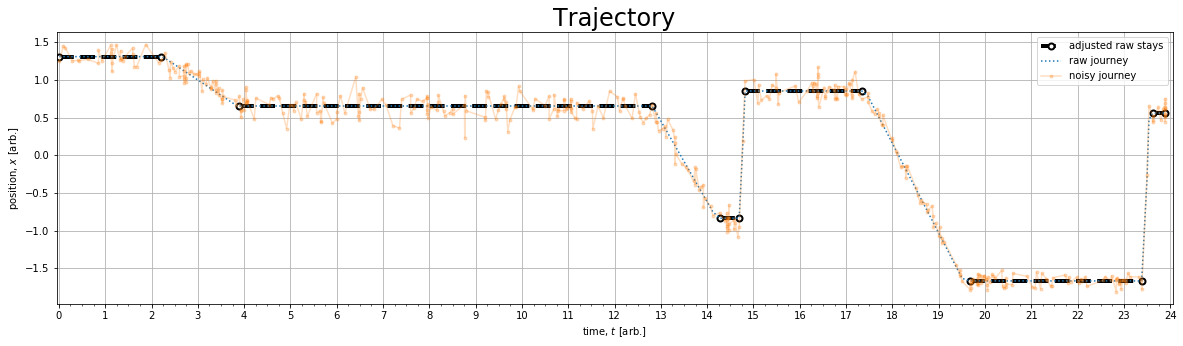

In [16]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

# Clustering

## Get intial clusters

## Split the clusters which have a temporal gap

In [47]:
time_thresh = 1/6
eps=0.25

In [18]:
get_err = lambda x1, x2: np.sqrt((x1-x2)**2) 

In [19]:
get_box_bounds = lambda sub_arr, eps: (np.mean(sub_arr), np.mean(sub_arr)+eps, np.mean(sub_arr)-eps)

In [20]:
def get_mini_box(time_ind_0, t_arr, loc_arr, dist_thresh, time_thresh, verbose=False):

    """
    Find the longest box of a given width to contain the maximum number of signaling events

    :param time_ind_0: int Starting timepoint
    :param time_ind: int Current timepoint    
    :param t_arr: np.array Trajectory array of timepoints
    :param loc_arr: np.array Trajectory array of locations
    :param dist_thresh: float Width of box
    :param time_thresh: float buff around timepoint      

    :return: int endpoint index of a region
    """

    # Set the (initial) metrics for the 'box' -- could update along the way
    time_ind = time_ind_0+1
    _, upper, lower = get_box_bounds(loc_arr[time_ind_0:time_ind], dist_thresh)

    # Set the sizes: exit once size does not change from last_size
    last_size = 0
    curr_size = 1

    increase_box = True
    while increase_box:

        # Extend the box forward in time; get the greatest timepoint in this region
        new_time = t_arr[time_ind]+time_thresh
        latest_time_ind = np.where(t_arr<=new_time)[0].max()

        # Using a sub-array, count all events within the 'box'
        subarr = loc_arr[time_ind_0:latest_time_ind]
        event_inds = np.where((subarr <= upper) & (subarr >= lower))[0]
        curr_size = event_inds.size

        # Report
        if verbose: print(last_size, '\t', curr_size,  '\t', latest_time_ind)

        # Check if the current size equals the last_size, and break
        # This means the search quits as soon as there's an outlier 
        # --> will catch more if the break criterion is more relaxed.
        if last_size == curr_size:
            break
        else:
            last_size = curr_size

        # Update the box
        _, upper, lower = get_box_bounds(loc_arr[time_ind_0:time_ind], dist_thresh)

        # Update the time index
        time_ind = latest_time_ind

    return time_ind

Cl. Nr.   1: 0 5,     5,    0.405
Cl. Nr.   2: 6 9,     3,    0.228
Cl. Nr.   3: 9 21,    12,    0.456
Cl. Nr.   4: 21 25,     4,    0.206
Cl. Nr.   5: 26 73,    42,    1.659
Cl. Nr.   6: 73 90,    17,    0.680
Cl. Nr.   7: 90 106,    15,    1.072
Cl. Nr.   8: 106 113,     7,    0.338
Cl. Nr.   9: 113 118,     5,    0.357
Cl. Nr.  10: 118 125,     6,    0.339
Cl. Nr.  11: 127 130,     3,    0.269
Cl. Nr.  12: 132 154,    22,    1.103
Cl. Nr.  13: 154 158,     3,    0.265
Cl. Nr.  14: 158 176,    16,    1.128
Cl. Nr.  15: 176 179,     3,    0.284
Cl. Nr.  16: 179 205,    26,    1.238
Cl. Nr.  17: 205 208,     3,    0.228
Cl. Nr.  18: 208 240,    18,    1.848
Cl. Nr.  19: 240 247,     6,    0.204
Cl. Nr.  20: 247 269,    20,    0.689
Cl. Nr.  21: 269 273,     4,    0.292
Cl. Nr.  22: 273 280,     7,    0.360
Cl. Nr.  23: 280 282,     2,    0.357
Cl. Nr.  24: 282 325,    40,    1.585
Cl. Nr.  25: 325 331,     6,    0.179
Cl. Nr.  26: 331 335,     3,    0.283
Cl. Nr.  27: 335 341,     6,  

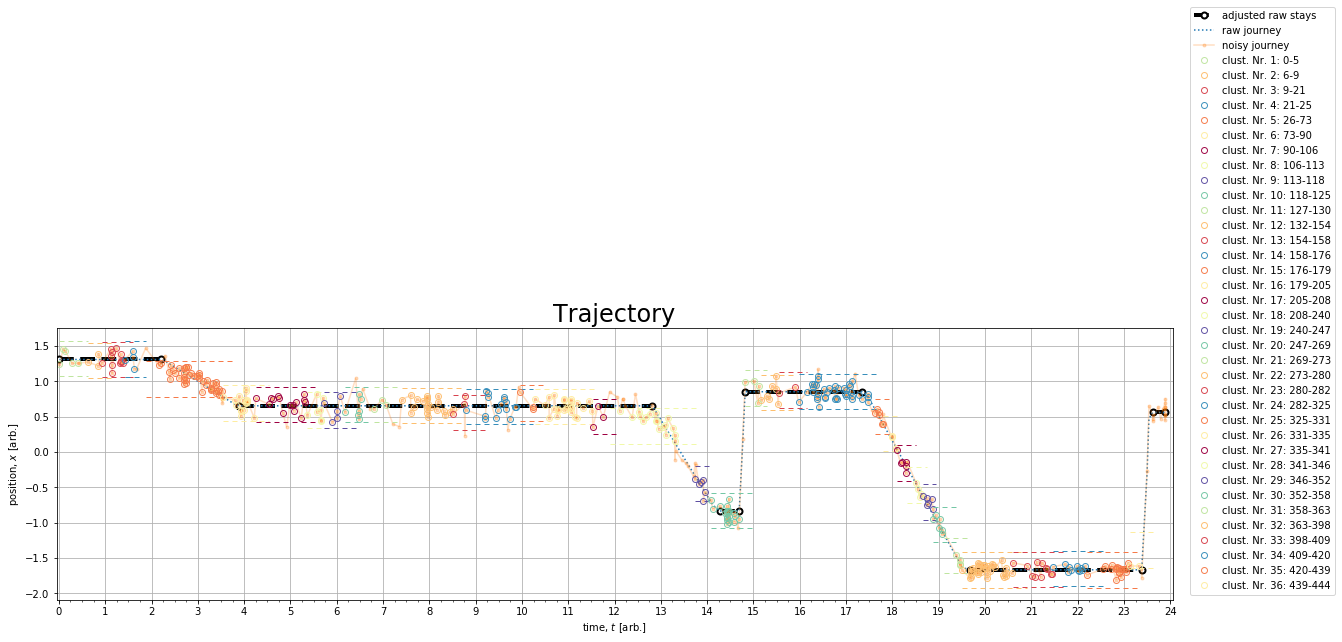

In [48]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

box_lines_dict = {'linestyle':'--','dashes':[5,4],'linewidth':1.0}

latest_time_ind = 0 #clusters[0][0]

epsi = eps/1.0
clust_nr = 1
while latest_time_ind+20 < len(time_arr):

    new_latest_time_ind = get_mini_box(latest_time_ind, time_arr, noise_arr, epsi, time_thresh, False)
    #new_latest_time_ind = get_boxed_cluster(latest_time_ind,latest_time_ind+20,time_arr, noise_arr, epsi, time_thresh)

    # 
    subarr =  noise_arr[latest_time_ind:new_latest_time_ind]
    subarr_time = time_arr[latest_time_ind:new_latest_time_ind]
    _, upper, lower = get_box_bounds(subarr, epsi)

    lino = str(latest_time_ind)+' '+str(new_latest_time_ind)
    if new_latest_time_ind+1 >= len(time_arr): 
        new_latest_time_ind = len(time_arr)-2
    lino2 = str(new_latest_time_ind)


    event_inds = np.where((subarr <= upper) & (subarr >= lower))[0]
    
    
    time_diff = abs(subarr_time[-1]-subarr_time[0])

    if (time_diff > time_thresh) & (event_inds.size > 0):
        
        color=colors[clust_nr%len(colors)]
        
        plt.plot([time_arr[latest_time_ind],time_arr[new_latest_time_ind+1]], [upper,upper], color=color, **box_lines_dict)
        plt.plot([time_arr[latest_time_ind],time_arr[new_latest_time_ind+1]], [lower,lower], color=color, **box_lines_dict)
        
        plt.plot(subarr_time[event_inds], subarr[event_inds], 'o', markerfacecolor="None", color=color, alpha=0.95, label=f'clust. Nr. {clust_nr}: {latest_time_ind}-{new_latest_time_ind}')
        print(f"Cl. Nr. {clust_nr:3d}: {lino}, {event_inds.size:5d}, {time_diff:8.3f}")        
        clust_nr += 1
    
    
    latest_time_ind = new_latest_time_ind
    
    #latest_time_ind < len(time_arr)
    
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
'''
plt.xlim([1,3])
ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.02))'''
#plt.xlim([5,10]);
#plt.xlim([18,22]);
plt.legend(bbox_to_anchor=(1.15, 0), loc='lower right', ncol=1);